In [1]:
import argparse
from pathlib import Path
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
import json
from models import UNet11
from dataset import WaterDataset
from torch.optim import lr_scheduler 
import torch.optim as optim
import numpy as np
import glob
import os
from metrics_prediction import calc_loss
import matplotlib.pyplot as plt
import utils_plot

from get_train_test_kfold import get_split_out, percent_split, get_split_in

from split_train_val import get_files_names
from scalarmeanstd import meanstd

from transformsdata import (DualCompose,
                        ImageOnly,
                        Normalize,
                        Normalize2,
                        HorizontalFlip,
                        Rotate,
                        CenterCrop,
                        VerticalFlip)

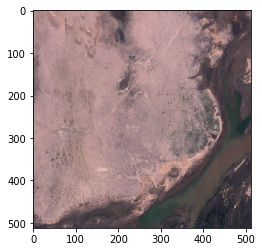

In [2]:
img = np.load(os.path.join('data/','train_val_850_2/images/rgbnir24608-3072.npy'))[:3]
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img.transpose(1,2,0))

## Definitions

In [3]:
num_classes = 1
input_channels = 4
batch_size = 4
lr = 0.005

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)


cuda:1


In [5]:
#Definition of teacher model
model_teach = UNet11(num_classes=num_classes, input_channels=input_channels)

In [6]:
if torch.cuda.is_available():
    model_teach = nn.DataParallel(model_teach, device_ids=[1])

In [7]:
data_path = Path("data/")


#Labeled images
train_val_file_names = np.array(sorted(glob.glob(str((data_path/'train_val_850_2'/'images'))+ "/*.npy")))
test_file_names = np.array(sorted(glob.glob(str((data_path/'test_850_2'/'images')) + "/*.npy")))

train_file_lab,val_file_lab = get_split_in(train_val_file_names,0)

max_values, mean_values, std_values=meanstd(train_file_lab, val_file_lab,test_file_names,str(data_path),input_channels)

print(mean_values, std_values, max_values)

elapsed time: 6.079475373961031
Train: data 751 min  0 max  3521
mean:[ 0.11289885  0.10246669  0.11346575  0.1396483 ]
std:[ 0.08914584  0.0666959   0.05693271  0.11042776]
Val: data 188 min  0 max  3440
mean:[ 0.11717311  0.10560063  0.1165011   0.13805926]
std:[ 0.09240376  0.06936888  0.05979758  0.11221593]
Test: data 182 -min  0 max  3272
mean:[ 0.10808238  0.09674959  0.10814647  0.13168366]
std:[ 0.08546968  0.06265724  0.05298235  0.10878518]
All: data 945 min  0 max  3521
mean:[ 0.11383374  0.10310764  0.11405758  0.13963067]
std:[ 0.08972336  0.06713878  0.05742005  0.11076992]
[ 0.11289885  0.10246669  0.11346575  0.1396483 ] [ 0.08914584  0.0666959   0.05693271  0.11042776] 3521


In [8]:
def make_loader(file_names, shuffle=False, transform=None, limit=None,  mode = "train",batch_size=4,limite=None) :
    return DataLoader(
        dataset=WaterDataset(file_names, transform=transform, mode = mode,limit=limit),
        shuffle=shuffle,
        batch_size= batch_size,
        pin_memory=False
    )

## Transformations

In [9]:
train_transform = DualCompose([
    CenterCrop(512),
    HorizontalFlip(),
    VerticalFlip(),
    Rotate(),
    ImageOnly(Normalize(mean=mean_values, std=std_values))
])

val_transform = DualCompose([
    CenterCrop(512),
    ImageOnly(Normalize(mean=mean_values, std=std_values))
])


In [ ]:
train_loader_lab = make_loader(train_file_lab, shuffle=True, transform=train_transform , batch_size = batch_size , mode = "train")
valid_loader_lab = make_loader(val_file_lab, transform=val_transform, batch_size = batch_size, mode = "train")

In [ ]:
dataloaders_lab= {
    'train': train_loader_lab, 'val': valid_loader_lab
}

In [ ]:
dataloaders_sizes = {
    x: len(dataloaders_lab[x]) for x in dataloaders_lab.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

## Printing some images and labels

In [ ]:
print('Training images (only RGB)')
images, labels = next(iter(train_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    print(images[ii].shape)
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    ax.imshow(labels[ii].squeeze().numpy())

In [ ]:
print('Validation images (only RGB)')
images, labels = next(iter(valid_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    print(images[ii].shape)
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    print(labels[ii])
    print(labels[ii].squeeze().numpy().shape)
    label = labels[ii].squeeze().numpy()
    print(label.min(), label.max())
    ax.imshow(label)

In [ ]:
optimizer_ft = optim.Adam(list(model_teach.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

## Training the Teacher Model

In [ ]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 10
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [ ]:
#Initializing model weights, loss and output file
import copy
import time
from collections import defaultdict
best_model_teach_wts = copy.deepcopy(model_teach.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [ ]:
for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model_teach.train()  # Set model to training mode
        else:
            model_teach.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_lab, labels_lab= next(iter(dataloaders_lab[phase]))    

            input_lab = input_lab.to(device)
            labels_lab = labels_lab.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_lab = model_teach(input_lab)
                loss = calc_loss(pred_lab, labels_lab, metrics)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_samples_loss += input_lab.size(0)
            epoch_samples_l2 += input_lab.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        print('{} loss {:.3f}'.format(phase, epoch_loss))
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            best_model_teach_wts = copy.deepcopy(model_teach.state_dict())


    time_elapsed = time.time() - since
    print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

In [ ]:
model_teach.load_state_dict(best_model_teach_wts)

# Generating labels for unlabeled dataset

In [17]:
#Unlabeled images

train_val_file_names_unlab = np.array(sorted(glob.glob(str((data_path/'unlabel'/'sftr'/'images'))+ "/*.npy")))
train_file_unlab,val_file_unlab = get_split_in(train_val_file_names_unlab,0)

In [ ]:
#Transforms
train_transform_unlab = DualCompose([
    CenterCrop(512),
    HorizontalFlip(),
    VerticalFlip(),
    Rotate(),
    ImageOnly(Normalize(mean=mean_values, std=std_values))
])

val_transform_unlab = DualCompose([
    CenterCrop(512),
    ImageOnly(Normalize(mean_values, std=std_values))
])

In [ ]:
#Train and validation loaders
train_loader_unlab = make_loader(train_file_unlab, shuffle=True, transform=train_transform, batch_size = batch_size//2, mode = "unlb_train")
valid_loader_unlab = make_loader(val_file_unlab, transform=val_transform, batch_size = batch_size//2, mode = "unlb_val")

In [ ]:
dataloaders_unlab= {
    'train': train_loader_unlab, 'val': valid_loader_unlab
}

In [ ]:
dataloaders_sizes = {
    x: len(dataloaders_unlab[x]) for x in dataloaders_unlab.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

In [ ]:
print('Generate masks from loaders:')
for loader in [train_loader_unlab, valid_loader_unlab]:
    for images, labels in iter(loader):
        for ii in range(len(images)):
            label = model_teach(images[ii].unsqueeze(0))
            label = torch.sigmoid(label.squeeze()).cpu().detach().numpy()
            mask = label[:,:] >= label.mean()

            img_name = labels[ii]
            pos = img_name.find("images")
            mask_name = img_name[:pos] + 'masks/' + img_name[pos+7:-4] + "_a.npy"
            mask = np.expand_dims(mask, axis=0)
            print(mask.shape)
            np.save(mask_name, mask)    
            print(mask_name)

## Preparing dataset for student model

In [ ]:
#Train and validation loaders, now in train mode since we have labels
train_loader_pseudo = make_loader(train_file_unlab, shuffle=True, transform=val_transform, batch_size = batch_size//2, mode = "train")
valid_loader_pseudo = make_loader(val_file_unlab, transform=val_transform, batch_size = batch_size//2, mode = "train")

In [ ]:
dataloaders_pseudo= {
    'train': train_loader_pseudo, 'val': valid_loader_pseudo
}

In [ ]:
dataloaders_sizes = {
    x: len(dataloaders_pseudo[x]) for x in dataloaders_pseudo.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

In [ ]:
print('Images with pseudolabels (only RGB)')
images, labels = next(iter(train_loader_pseudo))

fig, axes = plt.subplots(figsize=(10,4), ncols=2, nrows=2)
for ii in range(2):
    ax = axes[0][ii]
    print(images[ii].shape)
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    print(images[ii].unsqueeze(0).shape)
    
    ax = axes[1][ii]
    print(labels[ii])
    print(labels[ii].squeeze().numpy().shape)
    label = labels[ii].squeeze().numpy()
    print(label.min(), label.max())
    ax.imshow(label)

## Training student model

In [11]:
#Definition of the student model
model_stud = UNet11(num_classes=num_classes, input_channels=input_channels)

if torch.cuda.is_available():
    model_stud = nn.DataParallel(model_stud, device_ids=[1])

In [ ]:
optimizer_ft = optim.Adam(list(model_teach.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

In [ ]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 10
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [ ]:
best_model_stud_wts = copy.deepcopy(model_stud.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [ ]:
for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model_stud.train()  # Set model to training mode
        else:
            model_stud.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_pseudo, labels_pseudo= next(iter(dataloaders_pseudo[phase]))    

            input_pseudo = input_pseudo.to(device)
            labels_pseudo = labels_pseudo.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_pseudo = model_stud(input_pseudo)
                loss = calc_loss(pred_pseudo, labels_pseudo, metrics)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_samples_loss += input_pseudo.size(0)
            epoch_samples_l2 += input_pseudo.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        print('{} loss {:.3f}'.format(phase, epoch_loss))
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            best_model_stud_wts = copy.deepcopy(model_stud.state_dict())


    time_elapsed = time.time() - since
    print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

In [ ]:
torch.save(model_stud.state_dict(), "models/model_{}epoch_{}_fold{}.pth".format(num_epochs, "UNet11", "0"))

## Testing the student model

In [12]:
model_stud.load_state_dict(torch.load("models/model_10epoch_UNet11_fold0.pth"))

<All keys matched successfully>

In [13]:
test_loader = make_loader(test_file_names, transform=val_transform)

torch.Size([4, 512, 512])
torch.Size([1, 4, 512, 512])
tensor([[[1., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
(512, 512)
0.0 1.0
torch.Size([4, 512, 512])
torch.Size([1, 4, 512, 512])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
(512, 512)
0.0 0.0


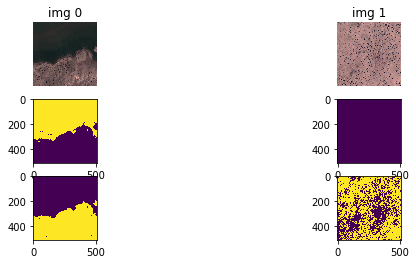

In [14]:
images, labels = next(iter(test_loader))

fig, axes = plt.subplots(figsize=(10,4), ncols=2, nrows=3)
for ii in range(2):
    ax = axes[0][ii]
    print(images[ii].shape)
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    print(images[ii].unsqueeze(0).shape)
    
    ax = axes[1][ii]
    print(labels[ii])
    print(labels[ii].squeeze().numpy().shape)
    label = labels[ii].squeeze().numpy()
    print(label.min(), label.max())
    ax.imshow(label)
    
    ax = axes[2][ii]
    label = model_stud(images[ii].unsqueeze(0))
    label = torch.sigmoid(label.squeeze()).cpu().detach().numpy()
    mask = label[:,:] >= label.mean()
    ax.imshow(mask)

In [15]:
from metrics_prediction import find_metrics

In [18]:
 find_metrics(train_file_names=train_file_unlab, 
                 val_file_names=val_file_unlab, 
                 test_file_names=test_file_names, 
                 max_values=max_values, 
                 mean_values=mean_values, 
                 std_values=std_values,
                 model=model_stud, 
                 fold_out=5, 
                 fold_in=5)   

182
train_VHR
Dice =  -2.85020906808 0.117948736275
Jaccard =  -2.98491460769 0.0280916392073 

val_VHR
Dice =  -2.74586969241 0.721216862715
Jaccard =  -2.8125 0.726184377414 

test_VHR
Dice =  -2.95417217327 0.291601001832
Jaccard =  -2.95650728889 0.291658891007 

